<a href="https://colab.research.google.com/github/zznadazz/eyes-disease/blob/main/Mespi_eyes_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install kaggle

In [ ]:
!pip install Augmentor

In [ ]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is incompatible.


In [ ]:
import os
import shutil
import openai
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import Augmentor
import random
from IPython.display import Image, display
from PIL import Image
from shutil import copyfile
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.applications.resnet_v2 import preprocess_input
from datetime import datetime
from tensorflow.keras.applications import InceptionV3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Image example of each class


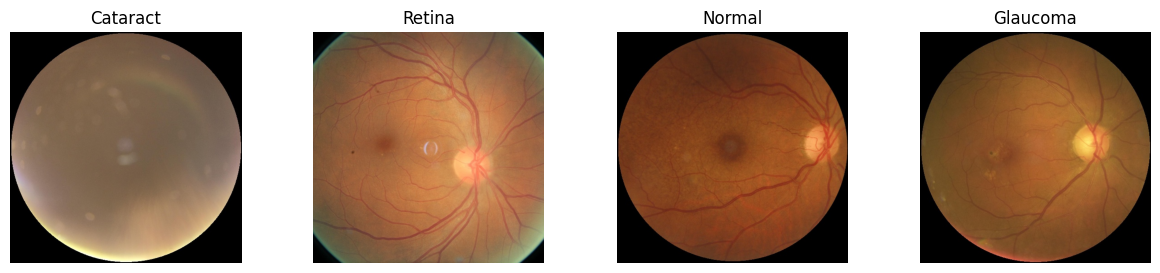

In [ ]:
from PIL import Image

classes = ['cataract', 'retina', 'normal', 'glaucoma']
base_path = '/content/drive/MyDrive/dataset/db'

fig, axes = plt.subplots(1, len(classes), figsize=(15, 3))

for i, class_name in enumerate(classes):
    files_list = [file for file in os.listdir(base_path) if file.startswith(class_name.lower())]

    if files_list:
        random_file = random.choice(files_list)
        image_path = os.path.join(base_path, random_file)

        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(class_name.capitalize())

plt.show()


#Unbalanced Data

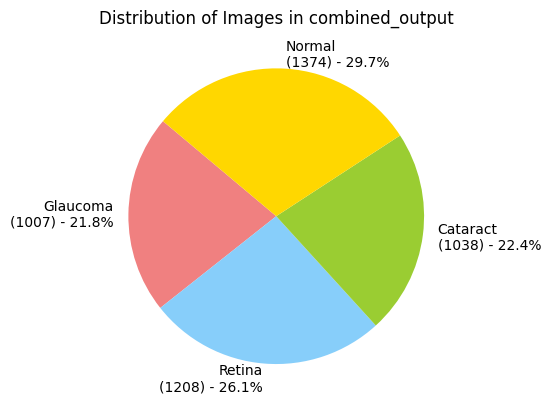

In [ ]:
import matplotlib.pyplot as plt
import os

combined_output_path = "/content/drive/MyDrive/dataset/db"
all_files = os.listdir(combined_output_path)


glaucoma_count = sum(1 for file in all_files if file.startswith('glaucoma'))
retina_count = sum(1 for file in all_files if file.startswith('retina'))
cataract_count = sum(1 for file in all_files if file.startswith('cataract'))
nl_count = sum(1 for file in all_files if file.startswith('normal'))


total_files = len(all_files)
glaucoma_percentage = (glaucoma_count / total_files) * 100
retina_percentage = (retina_count / total_files) * 100
cataract_percentage = (cataract_count / total_files) * 100
nl_percentage = (nl_count / total_files) * 100


labels = [f'Glaucoma\n({glaucoma_count}) - {glaucoma_percentage:.1f}%',
          f'Retina\n({retina_count}) - {retina_percentage:.1f}%',
          f'Cataract\n({cataract_count}) - {cataract_percentage:.1f}%',
          f'Normal\n({nl_count}) - {nl_percentage:.1f}%']
sizes = [glaucoma_count, retina_count, cataract_count, nl_count]
colors = ['lightcoral', 'lightskyblue', 'yellowgreen', 'gold']

plt.pie(sizes, labels=labels, colors=colors, autopct='', startangle=140)
plt.title('Distribution of Images in combined_output')
plt.show()


In [ ]:
def augment_images(original_images_path, output_directory, num_samples):
    p = Augmentor.Pipeline(original_images_path, output_directory)


    p.rotate(probability=1, max_left_rotation=5, max_right_rotation=5)
    p.flip_left_right(probability=0.5)
    p.zoom_random(probability=0.5, percentage_area=0.8)
    p.flip_top_bottom(probability=0.5)


    p.sample(num_samples)

In [ ]:
'''
def sort_files_into_classes(base_path, class_names):
    class_files = {class_name: [] for class_name in class_names}
    all_files = os.listdir(base_path)

    for file_name in all_files:
        for class_name in class_names:
            if file_name.startswith(class_name):
                class_files[class_name].append(file_name)

    return class_files

def select_random_sample(class_files, class_name, num_samples):
    selected_samples = random.sample(class_files[class_name], num_samples)
    return selected_samples

base_path = '/content/drive/MyDrive/dataset/db'
class_names = ['retina', 'normal', 'cataract', 'glaucoma']


class_files = sort_files_into_classes(base_path, class_names)

class_samples = {'retina': 300, 'normal': 150, 'cataract': 500, 'glaucoma': 500}


for class_name, num_samples in class_samples.items():
    selected_samples = select_random_sample(class_files, class_name, num_samples)

    for sample in selected_samples:
        source_path = os.path.join(base_path, sample)
        destination_filename = f"{class_name}_{sample}"
        destination_path = os.path.join(base_path, destination_filename)
        copyfile(source_path, destination_path)
        #print(f"Copied: {source_path} to {destination_path}")

'''

'\ndef sort_files_into_classes(base_path, class_names):\n    class_files = {class_name: [] for class_name in class_names}\n    all_files = os.listdir(base_path)\n\n    for file_name in all_files:\n        for class_name in class_names:\n            if file_name.startswith(class_name):\n                class_files[class_name].append(file_name)\n\n    return class_files\n\ndef select_random_sample(class_files, class_name, num_samples):\n    selected_samples = random.sample(class_files[class_name], num_samples)\n    return selected_samples\n\nbase_path = \'/content/drive/MyDrive/dataset/db\'\nclass_names = [\'retina\', \'normal\', \'cataract\', \'glaucoma\']\n\n\nclass_files = sort_files_into_classes(base_path, class_names)\n\nclass_samples = {\'retina\': 300, \'normal\': 150, \'cataract\': 500, \'glaucoma\': 500}\n\n\nfor class_name, num_samples in class_samples.items():\n    selected_samples = select_random_sample(class_files, class_name, num_samples)\n\n    for sample in selected_sampl

This step took me 8 minutes: 2min/class.

#Data augmentation

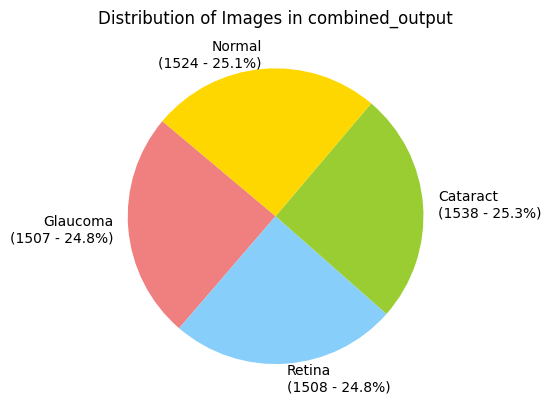

In [ ]:
import matplotlib.pyplot as plt
import os

combined_output_path = "/content/drive/MyDrive/dataset/dbaugmented"
all_files = os.listdir(combined_output_path)

glaucoma_count = sum(1 for file in all_files if file.startswith('glaucoma'))
retina_count = sum(1 for file in all_files if file.startswith('retina'))
cataract_count = sum(1 for file in all_files if file.startswith('cataract'))
nl_count = sum(1 for file in all_files if file.startswith('normal'))
#other_count = total_files - (glaucoma_count + retina_count + cataract_count + nl_count)

total_files = len(all_files)
glaucoma_percentage = (glaucoma_count / total_files) * 100
retina_percentage = (retina_count / total_files) * 100
cataract_percentage = (cataract_count / total_files) * 100
nl_percentage = (nl_count / total_files) * 100
#other_percentage = (other_count / total_files) * 100

labels = [f'Glaucoma\n({glaucoma_count} - {glaucoma_percentage:.1f}%)',
          f'Retina\n({retina_count} - {retina_percentage:.1f}%)',
          f'Cataract\n({cataract_count} - {cataract_percentage:.1f}%)',
          f'Normal\n({nl_count} - {nl_percentage:.1f}%)',
          ]
#f'Other\n({other_count} - {other_percentage:.1f}%)'
sizes = [glaucoma_count, retina_count, cataract_count, nl_count]
colors = ['lightcoral', 'lightskyblue', 'yellowgreen', 'gold', 'lightgray']


plt.pie(sizes, labels=labels, colors=colors, autopct='', startangle=140)
plt.title('Distribution of Images in combined_output')
plt.show()


In [ ]:
directory_path = combined_output_path
files = os.listdir(directory_path)

glaucoma_count = 0
nl_count = 0
retina_count = 0
cataract_count = 0
other_count = 0
other_files = []


for filename in files:
    if filename.startswith('2_glaucoma') or filename.startswith('glaucoma') :
        glaucoma_count += 1
    elif filename.startswith('1_normal') or filename.startswith('normal'):
        nl_count += 1
    elif filename.startswith('3_retina') or filename.startswith('retina'):
        retina_count += 1
    elif filename.startswith('2_cataract') or filename.startswith('cataract'):
        cataract_count += 1
    else:
        other_count += 1
        other_files.append(filename)

# Print the counts
print(f"Number of Glaucoma images: {glaucoma_count}")
print(f"Number of NL images: {nl_count}")
print(f"Number of Retina images: {retina_count}")
print(f"Number of Cataract images: {cataract_count}")
print(f"Number of other images: {other_count}")


Number of Glaucoma images: 1507
Number of NL images: 1524
Number of Retina images: 1508
Number of Cataract images: 1538
Number of other images: 0


Visualising categories

In [ ]:
len(files)

6077

In [ ]:
import os
import random

def shuffle_folder_content(folder_path):
    all_files = [filename for filename in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, filename))]
    random.shuffle(all_files)

# Example usage:

shuffle_folder_content(combined_output_path)


#Balanced and Augmented Data

#Train Test Split

In [ ]:
import shutil, random, os
dirpath = combined_output_path
allfiles = os.listdir(dirpath)
allfiles[:20]

['cataract_cataract__173_9178799.jpg',
 'cataract_cataract__249_4807123.jpg',
 'cataract_cataract__106_5284713.jpg',
 'cataract_cataract__253_643151.jpg',
 'cataract_cataract_2169_right.jpg',
 'cataract_cataract_2135_right.jpg',
 'cataract_cataract_2209_right.jpg',
 'cataract_cataract__340_3239094.jpg',
 'cataract_cataract_cataract_040.png',
 'cataract_cataract__88_1858467.jpg',
 'cataract_cataract_2206_left.jpg',
 'cataract_cataract__379_3919297.jpg',
 'cataract_cataract__311_3993772.jpg',
 'cataract_cataract__314_8935717.jpg',
 'cataract_cataract_477_left.jpg',
 'cataract_cataract_2241_left.jpg',
 'cataract_cataract_970_right.jpg',
 'cataract_cataract__96_5515894.jpg',
 'cataract_cataract__69_3198217.jpg',
 'cataract_cataract__198_3804403.jpg']

We notice that there are two types of images, those who come from our database and those who were the result of an an augmentation:


*  '1_normal_original_NL_036.png_9f0d8391-39da-4602-ab9a-116f4512c372.png',
*  'Retina_025.png',



Extracting classes

In [ ]:
import os
import re
directory_path = combined_output_path
#directory_path = "/content/shuffled_combined_data"
files = os.listdir(directory_path)

class_labels = []

for filename in files:
    match = re.search(r'_([^_]+)_\d+.png', filename)
    if match:
        label = match.group(1).lower()
        if label in ['cataract', 'retina', 'glaucoma', 'normal']:
            class_labels.append(label)
    else:
        label = filename.split('_')[0].lower()
        if label in ['cataract', 'retina', 'glaucoma', 'normal']:
            class_labels.append(label)


In [ ]:
def extract_class_names(directory_path):
    files = os.listdir(directory_path)

    keywords = ['normal', 'glaucoma', 'retina', 'cataract']

    class_names = []

    for filename in files:
        for keyword in keywords:
            if keyword.lower() in filename.lower():
                class_names.append(keyword.lower())
                break

    return class_names

In [ ]:
class_labels = extract_class_names(directory_path)

In [ ]:
len(class_labels)

6077

In [ ]:
class_labels[:10]

['cataract',
 'cataract',
 'cataract',
 'cataract',
 'cataract',
 'cataract',
 'cataract',
 'cataract',
 'cataract',
 'cataract']

In [ ]:
files[:10]

['cataract_cataract__173_9178799.jpg',
 'cataract_cataract__249_4807123.jpg',
 'cataract_cataract__106_5284713.jpg',
 'cataract_cataract__253_643151.jpg',
 'cataract_cataract_2169_right.jpg',
 'cataract_cataract_2135_right.jpg',
 'cataract_cataract_2209_right.jpg',
 'cataract_cataract__340_3239094.jpg',
 'cataract_cataract_cataract_040.png',
 'cataract_cataract__88_1858467.jpg']

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(class_labels)
y_encoded = tf.keras.utils.to_categorical(y_encoded)

# ResNet 50 Model

In [ ]:
X_train_files, X_test_files, y_train, y_test = train_test_split(files, y_encoded, test_size=0.2, random_state=42)

In [ ]:
def preprocess_images(images):
    X_preprocessed = []
    for a in images:
        img_path = os.path.join(dirpath, a)
        img = Image.open(img_path)
        img = img.resize((224, 224))
        x = image.img_to_array(img)
        #x = x/255
        x = preprocess_input(x)
        X_preprocessed.append(x)
    return np.array(X_preprocessed)


In [ ]:
from PIL import Image
X_train = preprocess_images(X_train_files)
X_test = preprocess_images(X_test_files)

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (4861, 224, 224, 3)
y_train shape: (4861, 4)


In [ ]:
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)
#for layer in base_model.layers:
#    layer.trainable = False


94668760/94668760 [==============================] - 6s 0us/step


In [ ]:
n_learning_rate = 0.01
#model.compile(optimizer=Adam(learning_rate=0.1), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
152/152 [==============================] - 93s 403ms/step - loss: 0.6094 - accuracy: 0.7677
Epoch 2/50
152/152 [==============================] - 60s 393ms/step - loss: 0.4261 - accuracy: 0.8426
Epoch 3/50
152/152 [==============================] - 61s 403ms/step - loss: 0.3334 - accuracy: 0.8790
Epoch 4/50
152/152 [==============================] - 62s 410ms/step - loss: 0.3303 - accuracy: 0.8772
Epoch 5/50
152/152 [==============================] - 61s 400ms/step - loss: 0.2761 - accuracy: 0.8963
Epoch 6/50
152/152 [==============================] - 59s 391ms/step - loss: 0.2214 - accuracy: 0.9212
Epoch 7/50
152/152 [==============================] - 60s 395ms/step - loss: 0.1967 - accuracy: 0.9241
Epoch 8/50
152/152 [==============================] - 60s 395ms/step - loss: 0.2053 - accuracy: 0.9245
Epoch 9/50
152/152 [==============================] - 62s 411ms/step - loss: 0.1927 - accuracy: 0.9259
Epoch 10/50
152/152 [==============================] - 62s 406ms/step - l

In [ ]:
y_pred = model.predict(X_test)

38/38 [==============================] - 7s 176ms/step


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy*100:.2f}%')

38/38 [==============================] - 7s 173ms/step - loss: 0.7249 - accuracy: 0.8487
Test Loss: 0.7249
Test Accuracy: 84.87%


In [ ]:
from sklearn.metrics import classification_report

# Assuming y_test is one-hot encoded
y_true_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       328
           1       0.85      0.82      0.84       304
           2       0.82      0.75      0.78       279
           3       0.79      0.96      0.87       305

    accuracy                           0.85      1216
   macro avg       0.85      0.85      0.85      1216
weighted avg       0.85      0.85      0.85      1216



<function matplotlib.pyplot.ylabel(ylabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

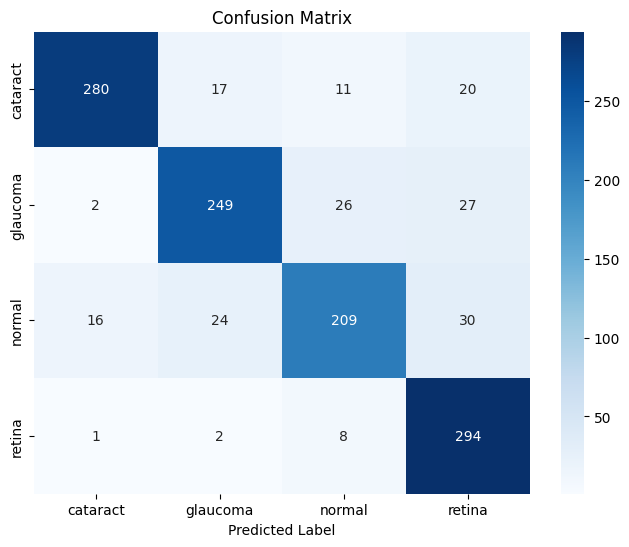

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)


conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel

Saving the model

In [ ]:
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
model_name = f'model_resnet_{timestamp}'
model_path = f'/content/drive/MyDrive/Mespi_models/{model_name}'
tf.saved_model.save(model, model_path)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
tflite_model = converter.convert()

In [ ]:
tflite_model_name = f'{model_name}.tflite'
tflite_model_path = f'/content/drive/MyDrive/Mespi_models/{tflite_model_name}'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# VGG-16 Model

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input

def preprocess_images_vgg(images):
    X_preprocessed = []
    for a in images:
        #img_path = '/content/output2/{}'.format(a)
        img_path = os.path.join(dirpath, a)
        img = Image.open(img_path)
        img = img.resize((224, 224))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        X_preprocessed.append(x)
    return np.array(X_preprocessed)


In [ ]:
X_train_vgg = preprocess_images_vgg(X_train_files)
X_test_vgg = preprocess_images_vgg(X_test_files)

print("X_train_vgg shape:", X_train_vgg.shape)
print("X_test_vgg shape:", X_test_vgg.shape)

X_train_vgg shape: (4861, 224, 224, 3)
X_test_vgg shape: (1216, 224, 224, 3)


In [ ]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model_vgg = Model(inputs=base_model.input, outputs=predictions)
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 7s 0us/step


In [ ]:
model_vgg.fit(X_train_vgg, y_train, epochs=50, batch_size=32)
y_pred_vgg = model_vgg.predict(X_test_vgg)

Epoch 1/50
152/152 [==============================] - 134s 717ms/step - loss: 1.7835 - accuracy: 0.3038
Epoch 2/50
152/152 [==============================] - 99s 654ms/step - loss: 1.2220 - accuracy: 0.4232
Epoch 3/50
152/152 [==============================] - 88s 581ms/step - loss: 1.0247 - accuracy: 0.5334
Epoch 4/50
152/152 [==============================] - 96s 631ms/step - loss: 0.8333 - accuracy: 0.6303
Epoch 5/50
152/152 [==============================] - 95s 626ms/step - loss: 0.7310 - accuracy: 0.6764
Epoch 6/50
152/152 [==============================] - 87s 572ms/step - loss: 0.6500 - accuracy: 0.7274
Epoch 7/50
152/152 [==============================] - 89s 589ms/step - loss: 0.5912 - accuracy: 0.7496
Epoch 8/50
152/152 [==============================] - 92s 604ms/step - loss: 0.5463 - accuracy: 0.7789
Epoch 9/50
152/152 [==============================] - 92s 606ms/step - loss: 0.5578 - accuracy: 0.7823
Epoch 10/50
152/152 [==============================] - 94s 620ms/step - 

In [ ]:
loss, accuracy = model_vgg.evaluate(X_test_vgg, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy*100:.2f}%')

38/38 [==============================] - 6s 149ms/step - loss: 0.4259 - accuracy: 0.8931
Test Loss: 0.4259
Test Accuracy: 89.31%


In [ ]:
y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred_vgg, axis=1))
y_true_labels = label_encoder.inverse_transform(np.argmax(y_test, axis=1))
print(classification_report(y_true_labels, y_pred_labels))

              precision    recall  f1-score   support

    cataract       0.89      0.97      0.92       328
    glaucoma       0.87      0.86      0.86       304
      normal       0.86      0.78      0.82       279
      retina       0.95      0.95      0.95       305

    accuracy                           0.89      1216
   macro avg       0.89      0.89      0.89      1216
weighted avg       0.89      0.89      0.89      1216



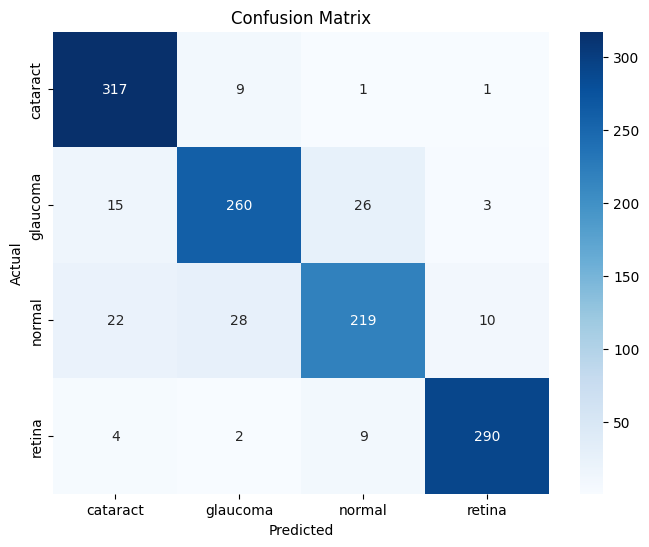

In [ ]:
conf_mat = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Saving the model

In [ ]:
timestamp_vgg = datetime.now().strftime("%Y%m%d%H%M%S")
model_name_vgg = f'model_vgg_{timestamp_vgg}'
model_vgg_path = f'/content/drive/MyDrive/Mespi_models/{model_name_vgg}'
tf.saved_model.save(model_vgg, model_vgg_path)

In [ ]:
converter_vgg = tf.lite.TFLiteConverter.from_saved_model(model_vgg_path)
tflite_model_vgg = converter_vgg.convert()

In [ ]:
tflite_model_name_vgg = f'{model_name_vgg}.tflite'
tflite_model_path_vgg = f'/content/drive/MyDrive/Mespi_models/{tflite_model_name_vgg}'
with open(tflite_model_path_vgg, 'wb') as f:
    f.write(tflite_model_vgg)

#Inceptionv3

In [ ]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

def preprocess_images_inceptionv3(images):
    X_preprocessed = []
    for img_name in images:
        img_path = os.path.join(dirpath, img_name)
        img = Image.open(img_path)
        img = img.resize((299, 299))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        X_preprocessed.append(x)
    return np.array(X_preprocessed)

In [ ]:
X_train_inc = preprocess_images_inceptionv3(X_train_files)
X_test_inc = preprocess_images_inceptionv3(X_test_files)

print("X_train_inc shape:", X_train_inc.shape)
print("X_test_inc shape:", X_test_inc.shape)

X_train_inc shape: (4861, 299, 299, 3)
X_test_inc shape: (1216, 299, 299, 3)


In [ ]:
base_model_inc = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))


x = base_model_inc.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)


model_inceptionv3 = Model(inputs=base_model_inc.input, outputs=predictions)
model_inceptionv3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 4s 0us/step


In [ ]:
model_inceptionv3.fit(X_train_inc, y_train, epochs=50, batch_size=32)

Epoch 1/50
152/152 [==============================] - 160s 772ms/step - loss: 0.5080 - accuracy: 0.8089
Epoch 2/50
152/152 [==============================] - 110s 723ms/step - loss: 0.3445 - accuracy: 0.8743
Epoch 3/50
152/152 [==============================] - 102s 675ms/step - loss: 0.2845 - accuracy: 0.8996
Epoch 4/50
152/152 [==============================] - 104s 683ms/step - loss: 0.2534 - accuracy: 0.9097
Epoch 5/50
152/152 [==============================] - 107s 707ms/step - loss: 0.2042 - accuracy: 0.9280
Epoch 6/50
152/152 [==============================] - 102s 670ms/step - loss: 0.1930 - accuracy: 0.9311
Epoch 7/50
152/152 [==============================] - 105s 693ms/step - loss: 0.1634 - accuracy: 0.9399
Epoch 8/50
152/152 [==============================] - 108s 710ms/step - loss: 0.1862 - accuracy: 0.9370
Epoch 9/50
152/152 [==============================] - 108s 712ms/step - loss: 0.1202 - accuracy: 0.9556
Epoch 10/50
152/152 [==============================] - 108s 714m

In [ ]:
y_pred_inc = model_inceptionv3.predict(X_test_inc)
loss, accuracy = model_inceptionv3.evaluate(X_test_inc, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy*100:.2f}%')

38/38 [==============================] - 12s 280ms/step - loss: 0.6437 - accuracy: 0.8783
Test Loss: 0.6437
Test Accuracy: 87.83%


In [ ]:
timestamp_inceptionv3 = datetime.now().strftime("%Y%m%d%H%M%S")
model_name_inceptionv3 = f'model_inceptionv3_{timestamp_inceptionv3}'
model_inceptionv3_path = f'/content/drive/MyDrive/Mespi_models/{model_name_inceptionv3}'
tf.saved_model.save(model_inceptionv3, model_inceptionv3_path)

In [ ]:
converter_inceptionv3 = tf.lite.TFLiteConverter.from_saved_model(model_inceptionv3_path)
tflite_model_inceptionv3 = converter_inceptionv3.convert()

In [ ]:
tflite_model_name_inceptionv3 = f'{model_name_inceptionv3}.tflite'
tflite_model_path_inceptionv3 = f'/content/drive/MyDrive/Mespi_models/{tflite_model_name_inceptionv3}'
with open(tflite_model_path_inceptionv3, 'wb') as f:
    f.write(tflite_model_inceptionv3)